The Annotated S4. https://srush.github.io/annotated-s4/. by Sasha Rush and Sidd Karamcheti, v3. 
- - -

In [ ]:
# ================================================
#  Library
# ================================================
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

rng = jax.random.PRNGKey(1)

## Part 1: State Space Models

$$
x'(t) = \mathbf{A}x(t) + \mathbf{B}u(t) \\
y(t) = \mathbf{C}x(t) + \mathbf{D}u(t)
$$

$\mathbf{A, B, C, D}$がパラメータ。今回は$\mathbf{D}u$という項はスキップ接続と見なすことができ、計算が簡単であるため$\mathbf{D}$は$0$とする。  
$u_{t}$をinput, $x(t), y(t)$がoutput。

In [ ]:
def random_SSM(rng, N: int):
    """A, B, Cの値をランダムに設定する
    Args:
        rng: a PRNG key (from ``PRNGKey``, ``split``, ``fold_in``).
        N(int): 正方行列A, B, Cの行数または列数

    Returns:
        パラメータA, B, C
    """
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, N))
    C = jax.random.uniform(c_r, (N, N))
    return A, B, C

### Discrete-time SSM: The Recurrent Representation

連続関数である$u_{t}$の代わりに離散$(u_{0}, u_{1}, \dots)$にすることで、SSMは**step size** $\Delta$で離散化しなければならない。離散化するためにbilinear method(双一次変換)を用いる。

$$
\bar{\mathbf{A}} = (\mathbf{I} - \Delta/2・\mathbf{A})^{-1}(\mathbf{I}+ \Delta/2・\mathbf{A}) \\
\bar{\mathbf{B}} = (\mathbf{I} - \Delta/2・\mathbf{A})^{-1}\Delta \mathbf{B}\\
\bar{\mathbf{C}} = \mathbf{C}
$$

$u_{k}$は$u(t)$からのサンプルだと考えることができる。$u_{k} = u(k\Delta)$

In [ ]:
def discretize(A, B, C, step):
    """uの離散化に伴ってSSMのパラメータも変化させる

    Args:
        A, B, C: 状態空間モデルのパラメータ
        step: 離散化させる幅

    return:
        変化させたパラメータA, B, C
    """
    I = np.eye(A.shape[0]) # np.eye(N: int): 単位行列
    BL = inv(I - (step / 2.0) * A) # inv: 逆行列
    Ab = BL @ (I + (step / 2.0) * A) # @: 行列の積
    Bb = (BL * step) @ B
    return Ab, Bb, C

uを離散化したことでsequence-to-sequenceとなる。$u_{k} \mapsto y_{k}$   
さらに状態方程式(the state equation)は$x_{k}$によって再帰されているのでdiscrete-SSMはRNNのように計算することができる。具体的には$x_{k} \in \mathbb{R}^{N}$はhidden_stateとして考えられる。

$$
x_{k} = \bar{\mathbf{A}}x_{k-1} + \bar{\mathbf{B}}u_{k}, \\
y_{k} = \bar{\mathbf{C}}x_{k}
$$

In [ ]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    """パラメータをRNNのように再帰的に求める

    Args:
        Ab, Bb, Cb: 状態空間モデルのパラメータ
        u: 入力
        x0: xの初期状態
    """
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k
    return jax.lax.scan(f = step, init = x0, xs = u)

In [ ]:
def run_SSM(A, B, C, u):
    L = u.shape[0]
    N = A.shape[0]
    Ab, Bb, Cb = discretize(A, B, C, step=1.0/L)

    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N, )))[1]

### Training SSMs: The Convolutional Representation
目的：RNNをCNNに変換して計算を高速化する

線形時不変状態空間モデルと連続的なたたみ込みにはよく知られた関連性がある。そしてthe recurrent SSMは実はdiscrete convolutionとして表せる。 
$x_{-1}=0$とすると
$$
x_{0} = \bar{\mathbf{B}}u_{0}, x_{1} = \bar{\mathbf{A}}\bar{\mathbf{B}}u_{0} + \bar{\mathbf{B}}u_{1}, \dots \\
y_{0} = \bar{\mathbf{C}}\bar{\mathbf{B}}u_{0}, y_{1} = \bar{\mathbf{C}}\bar{\mathbf{A}}\bar{\mathbf{B}}u_{0}+ \bar{\mathbf{C}}\bar{\mathbf{B}}u_{1}, y_{2} = \bar{\mathbf{C}}\bar{\mathbf{A}}^{2}\bar{\mathbf{B}}u_{0} + \bar{\mathbf{C}}\bar{\mathbf{A}}\bar{\mathbf{B}}u_{1} + \bar{\mathbf{C}}\bar{\mathbf{B}}u_{2}, \dots
$$

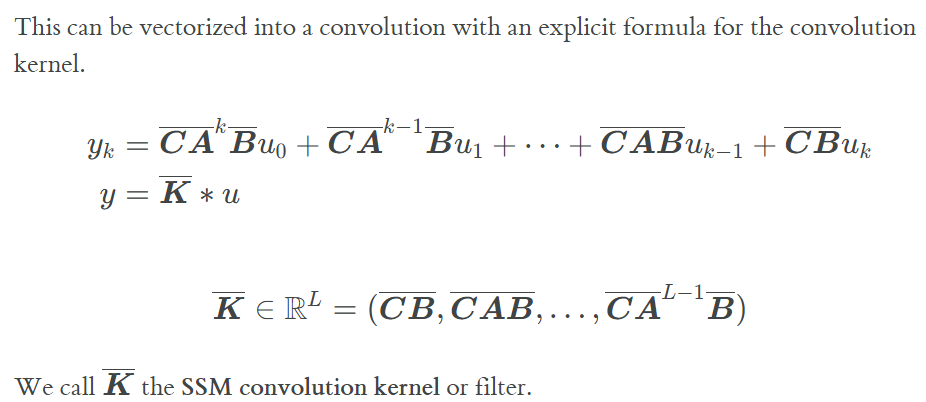

In [ ]:
def K_conv(Ab, Bb, Cb, L):
    # matrix_power: 行列の累乗
    return np.array(
        [(Cb @ matrix_power(Ab, n=l) @ Bb).reshape() for l in range(L)]
    )
#実装は不安定で非常に短い長さを超えると機能しない。あとで書きかえる。

このフィルタを適用した結果を計算する方法として、標準的な直接畳み込みや高速フーリエ変換（FFT）を用いた畳み込み定理を使用することができます。離散畳み込みの定理（二つの系列の循環畳み込みの場合）により、入力系列のFFTを掛け合わせ、逆FFTを適用することで効率的に畳み込みの出力を計算することができます。私たちの場合は循環畳み込みではないため、この定理を非循環畳み込みに利用するためには、入力系列をゼロでパディングし、出力系列を元の長さに戻す必要があります。入力系列の長さが長くなるほど、このFFT法は直接畳み込みよりも効率的になります。

具体的に言うと、FFTを使用した畳み込みでは、入力系列をFFTに変換することで周波数領域での乗算が行われます。その後、逆FFTを適用することで時間領域に戻し、畳み込みの結果を得ることができます。非循環畳み込みでは、入力系列をゼロでパディングすることで、FFTの長さを調整し、出力系列を元の長さに戻すことで正確な結果を得ることができます。

このFFT法を使用すると、入力系列の長さが長くなるほど計算効率が向上します。従って、直接畳み込みよりも高速に畳み込みを行うことができます。ただし、パディングや逆パディングによる余分な処理が必要となるため、計算効率と処理のオーバーヘッドのトレードオフを考慮する必要があります。

In [ ]:
def causal_convolution(u, k, nofft=False):
    if nofft:
        return convolve(u, k, mode="full")[:, u.shape[0]]
    else:
        assert K.shape[0] == u.shape[0]
        ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
        out = ud * kd
        return np.fft.irfft(out)[:, u.shape[0]]

In [ ]:
def test_cnn_is_rnn(N=4, L=16, step=1.0/16):
    ssm = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L, ))
    jax.random.split(rng, 3)

    # RNN
    rec = run_SSM(*ssm, step=step)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = causal_convolution(u, K_conv(*ssmb, L))
    
    # chech if cnn result is the same as rnn result
    assert np.allclose(rec.rabel(), conv.rabel())

### An SSM Neural Network

In [ ]:
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(key, shape):
        return jax.random.uniform(key, shape) * (
            np.log(dt_max) - np.log(dt_min)
        ) + np.log(dt_min)
    return init

In [ ]:
class SSMLayer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    def setup(self):
        # SSM parameters
        self.A = self.param("A", lecun_normal(), (self.N, self.K))
        self.B = self.param("B", lecun_normal(), (self.N, self.K))
        self.C = self.param("C", lecun_normal(), (self.N, self.K))
        self.D = self.param("D", lecun_normal(), (self.N, self.K))

        # step parameter
        self.log_step = self.param("log_step", log_step_initializer(), (1, ))


        step = np.exp(self.log_step)
        self.ssm = discretize(self.A, self.B, self.C, step=step)
        self.K = K_conv(*self.ssm, self.l_max)

        # RNN cashe for Long sequences
        self.x_k_1 = self.variable("cashe", "cashe_x_k", np.zeros, (self.N, ))

    def __call__(self, u):
        if not self.decode:
            # CNN mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cashe"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

In [ ]:
def cloneLayer(layer):
    return nn.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes = {"params":1, "cashe":1, "prime";1},
        split_rngs={"params":True},
    )

In [ ]:
SSMLayer = cloneLayer(SSMLayer)

普通のNNに組み込むためのblockを作成

In [ ]:
class SequenceBlock(nn.Module):
    layer_cls: nn.Module
    layer: dict
    dropout: float
    d_model: int
    pernorm: bool = True
    glu: bool = True
    training: bool = True
    decode: bool = False

    def setup(self):
        self.seq = self.layer_cls(**self.layer, decode=self.decode)
        self.norm = nn.LayerNorm()
        self.out = nn.Dense(self.d_model)
        if self.glu:
            self.out2 = nn.Dense(self.d_model)
        self.drop = nn.Dropout(
            self.dropout,
            breadcast_dims = [0],
            deterministic=not self.training,
        )

    def __call__(self, x):
        skip = x
        if self.prenorm:
            x = self.norm(x)
        x = self.seq(x)
        x = self.drop(nn.glue(x))
        if self.glu:
            x = self.out(x) * jax.nn.sigmoid(self.out2(x))
        else:
            x = self.out(x)
        x = skip + self.drop(x)
        if not self.prenorm:
            x = self.norm(x)
        return x

これらを積み重ねる

In [ ]:
class Embedding(nn.Embed):
    num_embeddings: int
    features: int

    @nn.compact
    def __call__(self, x):
        y = nn.Embed(self.num_embeddings, self.features)(x[..., 0])
        return np.where(x > 0, y, 0.0)

In [ ]:
class StackedModel(nn.Module):
    layer_cls: nn.Module
    layer: dict
    d_output: int
    d_model: int
    n_layers: int
    prenorm: bool = True
    dropout: float = 0.0
    embedding: bool: False
    classification: bool = False
    training: bool = True
    decode: bool = False

    def setup(self):
        if self.embedding:
            self.encoder = Embedding(self.d_output, self.d_model)
        else:
            self.encoder = nn.Dense(self.d_model)
        self.decoder = nn.Dense(self.d_output)
        self.layers = [
            SequenceBlock(
                layer_cls = self.layer_cls,
                layer = self.layer,
                prenorm = self.prenorm,
                d_model = self.d_model,
                dropout = self.dropout,
                training = self.training,
                decode = self.decode,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self,x):
        if not self.classification:
            if not self.embedding:
                x = x/255.0
            if not self.decode:
                x = np.pad(x[:-1], [(1, 0), (0, 0)])
        x = self.encoder(x)
        for layer in self.layers:
            x = layer(x)
        if self.classification:
            x = np.mean(x, axis=0)
        x = self.decoder(x)
        return nn.log_softmax(x, axis=-1)

In [ ]:
BatchStackedModel = nn.vmap(
    StackedModel,
    in_axes=0,
    out_axes=0,
    variable_axes = {"params":None,
                     "dropout":None,
                     "cashe": 0,
                     "prime": None},
    split_rngs = {"params":False,
                  "dropout":True}
)

* まず、ランダムに初期化された SSM は実際にはあまり良好なパフォーマンスを発揮しません。 さらに、これまでのように単純に計算すると非常に遅くなり、メモリ効率も悪くなります。
* 長距離の依存関係に対する特別な初期化を定義することで、S4 のモデリングの側面についての議論を完了し、この SSM レイヤーをより高速に計算する方法を理解します

完全なtraining scriptはhttps://github.com/srush/annotated-s4/blob/main/s4/train.py

### Part 1b: Addressing Long-Range Dependencies with HiPPO

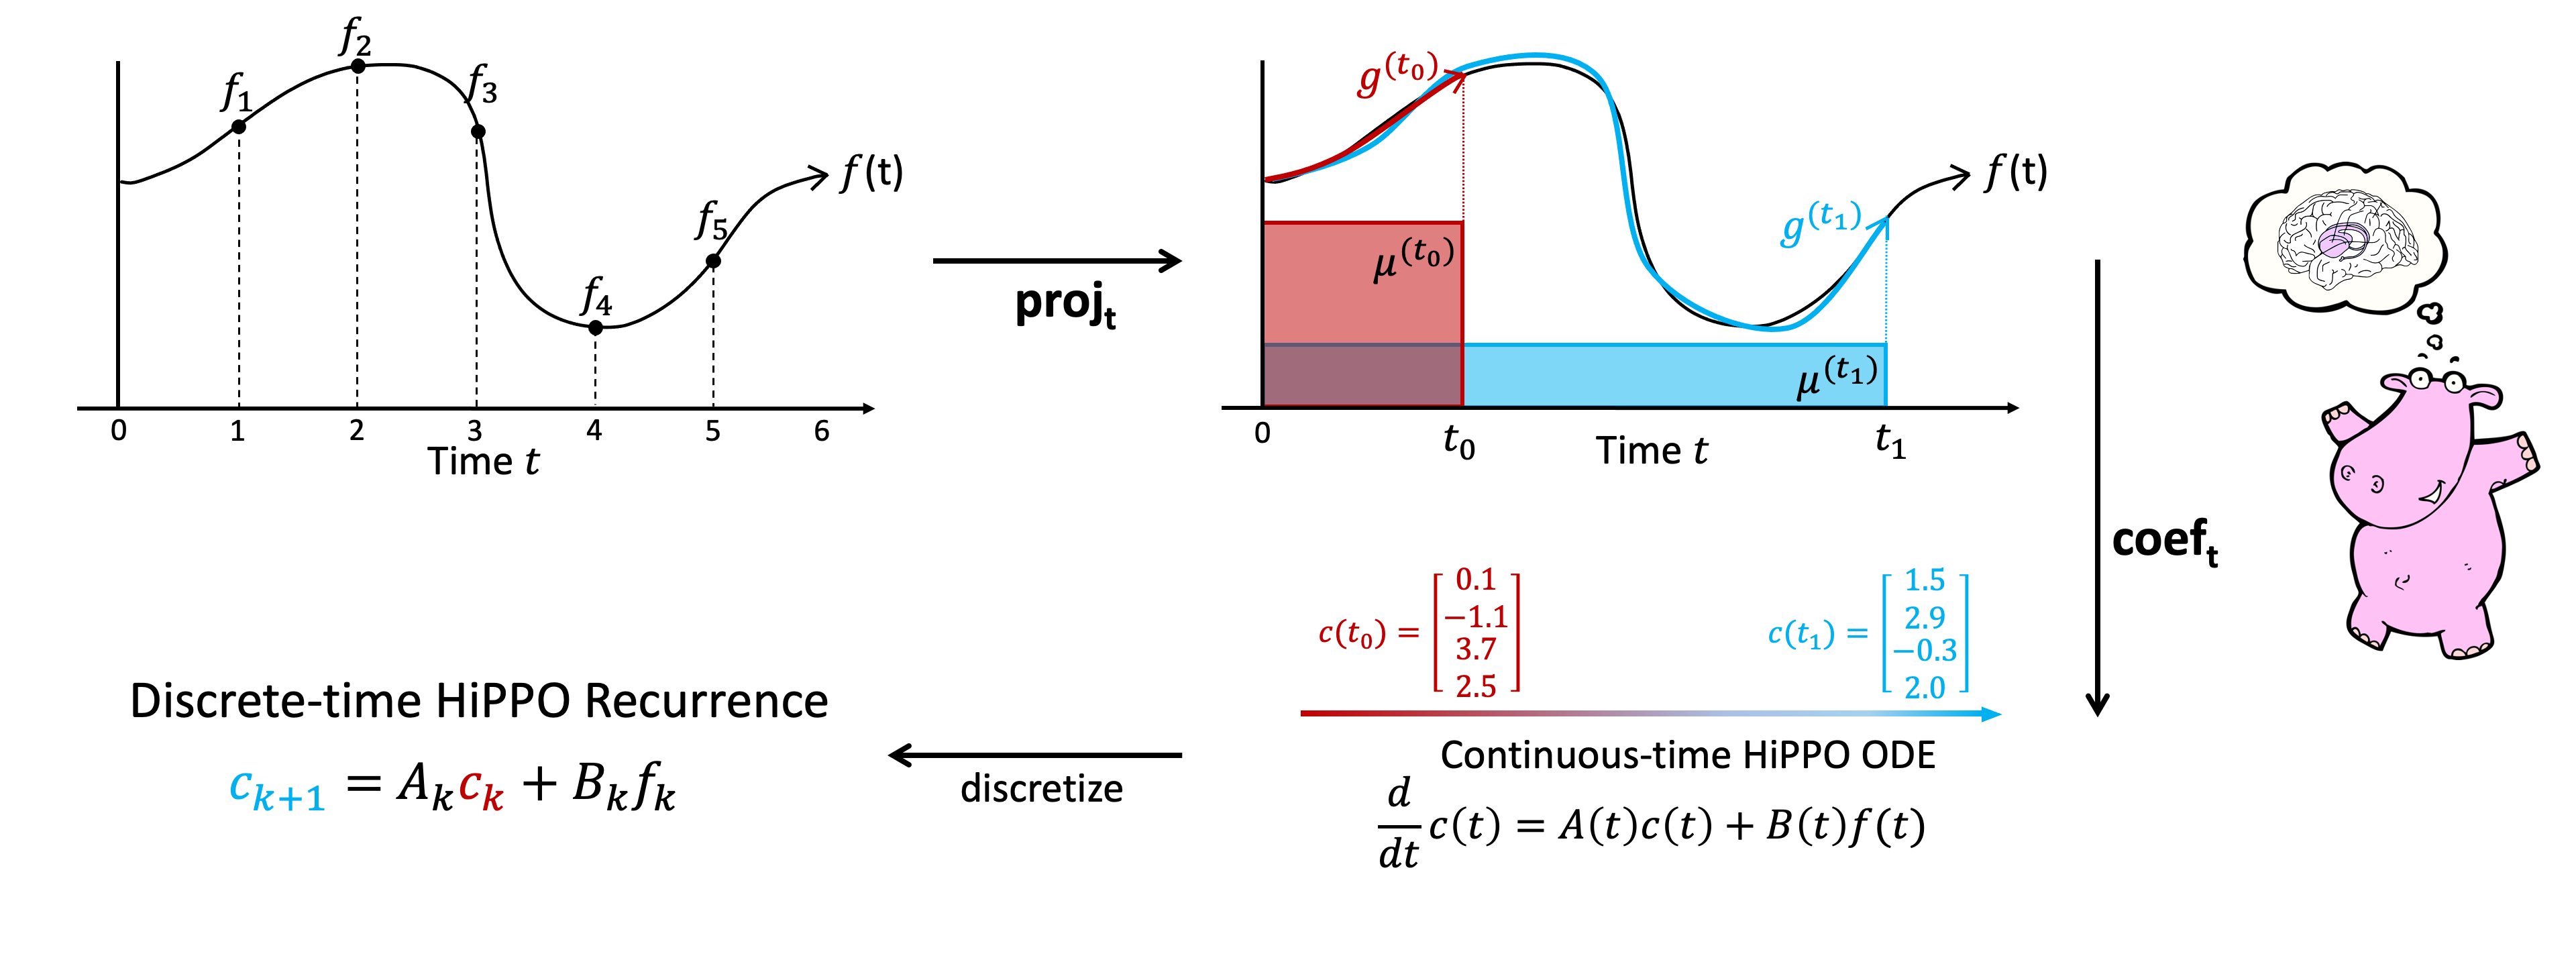

先行研究において、基本的なSSMはシーケンスの長さが増加すると勾配問題が起こっていたためパフォーマンスが非常にひどかった。この問題に対処するために、先行研究で連続時間記憶HiPPO理論が開発された。

HiPPO Matrix:
$$
\mathbf{A}_{nk} = 
   \left\{
      \begin{align*}
      (2n+1)^{1/2}(2k+1)^{1/2}, \qquad & \text{if} \quad n > k \\
      n+1, \qquad & \text{if} \quad n = k \\
      0, \qquad & \text{if} \quad n < k
      \end{align*}
   \right.
$$

* 1) 計算する必要があるのは 1 回だけであること
* 2) 構造が素晴らしく単純であること

ODEの計算をするまでもなく、この行列は過去の歴史を圧縮して、歴史をおおよそ再構築するのに十分な情報を持つ状態にすることを目的としているということが主な要点です。

In [1]:
def make_HiPPO(N):
    P = np.sqrt(1 + 2 * np.arange(N))
    A = P[:, np.newaxis] * P[np.newaxis, :]
    A = np.tril(A) - np.diag(np.arange(N))
    return -A

この行列を直感的に説明すると、履歴を記憶する「隠れ状態」を生成するものである。これは、ルジャンドル多項式の係数を記録しておくことで実現します。この係数によって、過去の履歴をすべて近似することができるのです。例を見てみよう、

ルジャンドル多項式の定義
  
$$
P_{n}(x) = \frac{(-1)^n}{2^{n}n!} \frac{d^n}{dx^n}(1-x^2)^n\\
(n=0, 1, 2, \dots)
$$


In [6]:
def example_legendre(N=8):
    # Random hidden state as coefficients
    import numpy as np
    import numpy.polynomial.legendre

    x = (np.random.rand(N) - 0.5) * 2
    t = np.linspace(-1, 1, 100)
    f = numpy.polynomial.legendre.Legendre(x)(t)

    # Plot
    import matplotlib.pyplot as plt
    import seaborn

    seaborn.set_context("talk")
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection="3d")
    ax.plot(
        np.linspace(-25, (N - 1) * 100 + 25, 100),
        [0] * 100,
        zs=-1,
        zdir="x",
        color="black",
    )
    ax.plot(t, f, zs=N * 100, zdir="y", c="r")
    for i in range(N):
        coef = [0] * N
        coef[N - i - 1] = 1
        ax.set_zlim(-4, 4)
        ax.set_yticks([])
        ax.set_zticks([])
        # Plot basis function.
        f = numpy.polynomial.legendre.Legendre(coef)(t)
        ax.bar(
            [100 * i],
            [x[i]],
            zs=-1,
            zdir="x",
            label="x%d" % i,
            color="brown",
            fill=False,
            width=50,
        )
        ax.plot(t, f, zs=100 * i, zdir="y", c="b", alpha=0.5)
    ax.view_init(elev=40.0, azim=-45)
    fig.savefig("images/leg.png")

In [8]:
if False:
    example_legendre()

赤い線は近似している曲線を表し、黒いバーは隠れた状態の値を表します。 それぞれは、青い関数として示されているルジャンドル級数の 1 つの要素の係数です。 直観的には、HiPPO 行列がこれらの係数をステップごとに更新するということです。

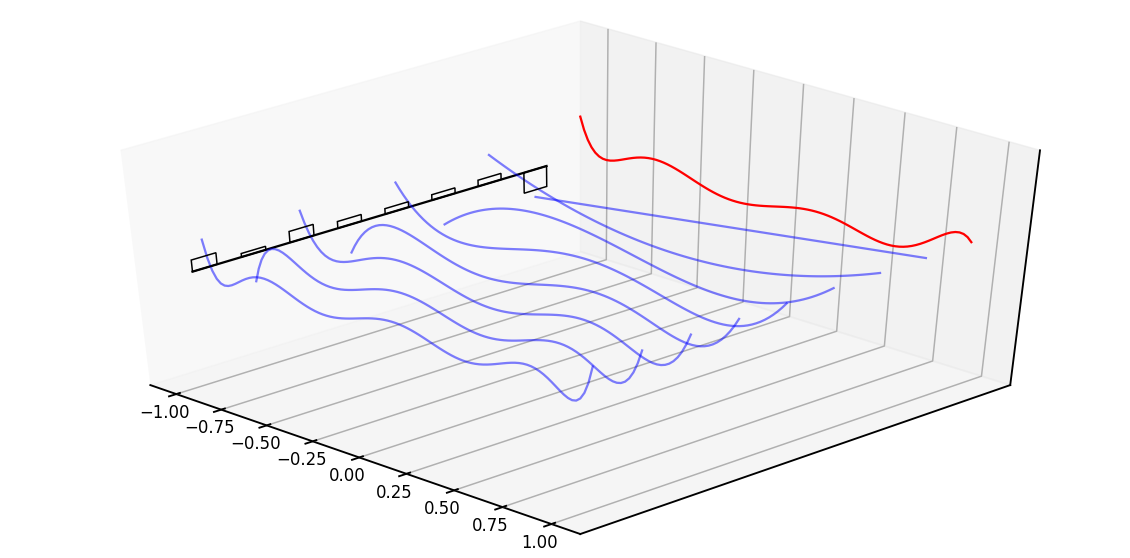

## Part2: Implementing S4
 “HiPPO-like” matrices really fast.  
 basic SSMとS4の違い
 * 1 つ目は、モデリングの課題である長距離依存関係に、特別な式を使用して対処します。

* 2つ目は、この行列を操作できるようにする特別な表現とアルゴリズムを導入することで、SSM の計算上の課題を解決します。

In [ ]:
# 改善前
def K_conv(Ab, Bb, Cb, L):
   return np.array(
       [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
   )

Diagonal Plus Low-Rank (DPLR) 
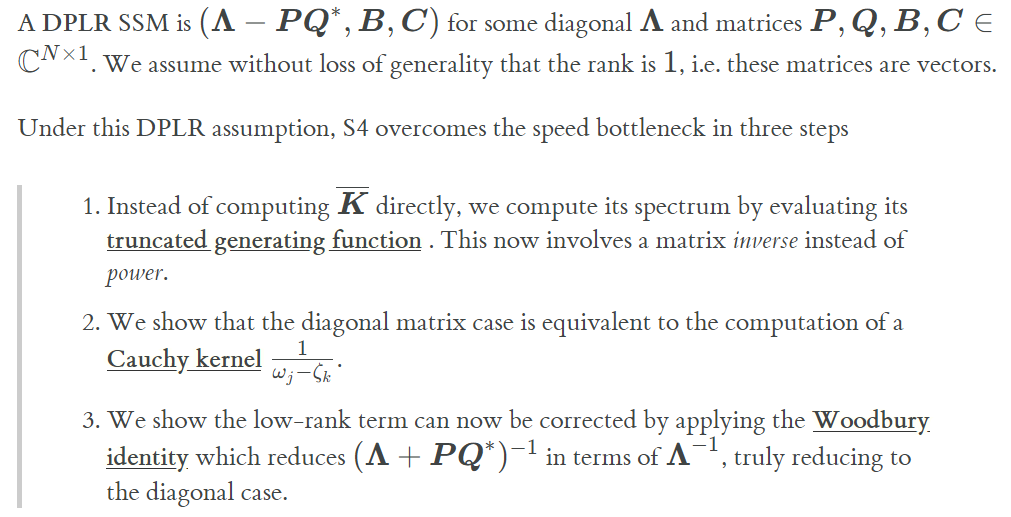

[Woodbury-identity](https://manabitimes.jp/math/1041): 逆行列の補助定理  
行列$A, B, C, D$に対して 
$$
(A + BDC)^{-1} = A^{-1} - A^{-1}B(D^{-1}+CA^{-1}BCA^{-1}
$$
ただし行列の積が定義できるような適切なサイズ、および$A$などの逆行列の存在を仮定する。  
特に $D= I$のとき、
$$
(A+BC)^{-1} = A^{-1} - A^{-1}B(I+CA^{-1}B)^{-1}CA^{-1}
$$

### Step 1. SSM Generating Functions
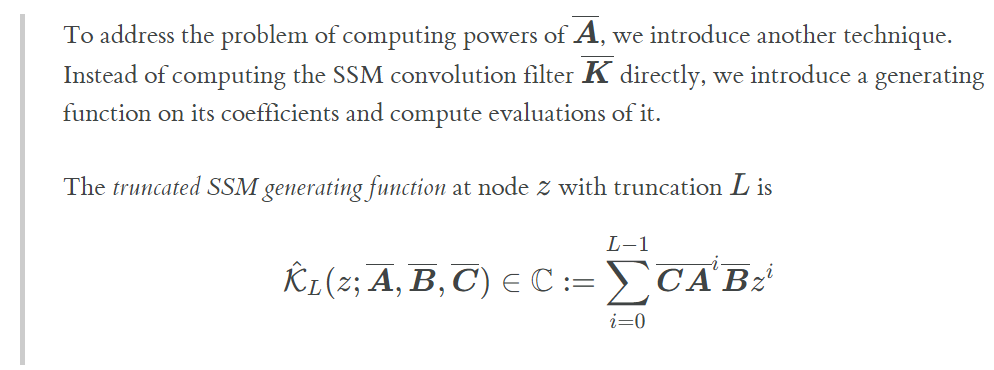

In [ ]:
def K_gen_simple(Ab, Bb, Cb, L):
    K = K_conv(Ab, Bb, Cb, L)

    def gen(z):
        return np.sum(K * (z ** np.arange(L)))

    return gen

[z-transform](https://www.momoyama-usagi.com/entry/math-seigyo01)  
ある数列$x_{n}$に対して、
$$
X(z) = \sum_{n=0}^{\infty}{x_{n}z^{-n}}
$$
の無限級数の形で表される$z$の関数$X(s)$のことをz変換という。

The generating function essentially converts the SSM convolution filter from the time domain to frequency domain. 

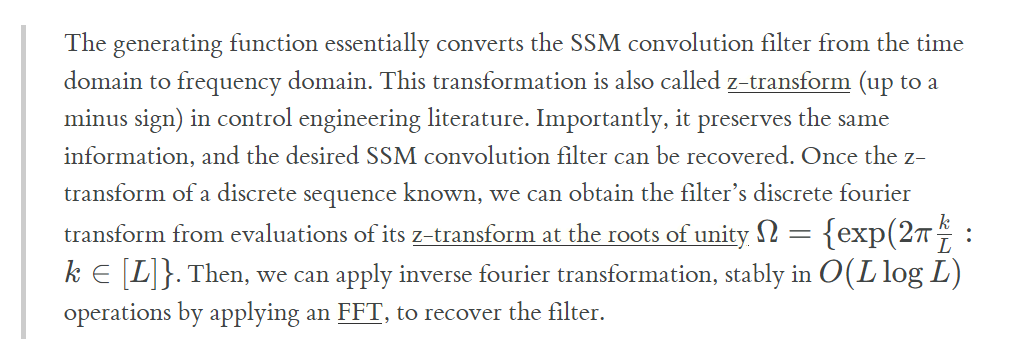

In [ ]:
def conv_from_gen(gen, L):
    Omega_L = np.exp((-2j * np.pi) * (np.arange(L) / L))

    # atRoots = torch.tensor([gen(Omega) for Omega in Omega_L])
    atRoots = jax.vmap(gen)(Omega_L)

    # Compute the one-dimensional inverse discrete Fourier Transform.
    out = np.fft.ifft(atRoots, L).reshape(L)
    return out.real

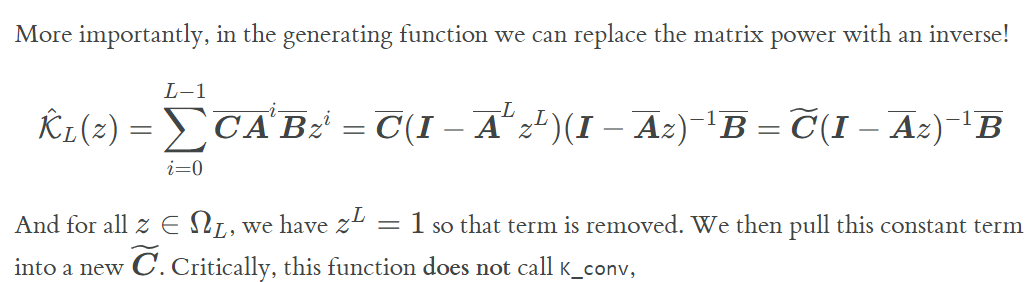

In [ ]:
def K_gen_inverse(Ab, Bb, Cb, L):
    I = np.eys(Ab.shape[0])
    Ab_L = matrix_power(Ab, L)
    Ct = Cb @ (I- Ab_L)
    return lambda z: (Ct.conj() @ inv(I - Ab * z) @ Bb).reshape(-1)

In [ ]:
def test_gen_inverse(L = 16, N = 4):
    ssm = random_SSM(rng, N)
    ssm = discreate(*ssm, 1.0/L)
    b = K_conv(*ssm, L=L)

    a = conv_from_gen(K_gen_inverse(*ssm, L=L), L)
    assert np.allclose(a, b)

まとめると、ステップ1では、切断された生成関数を利用することで、行列のべき乗を逆行列に置き換えることができます。しかし、この逆行列はまだ計算する必要があります L回（Unityの根のそれぞれについて）計算する必要があります。

## Step 2: Diagonal Case  
The next step to assume special structure on the matrix $A$ to compute the inverse faster than the naive inversion.  
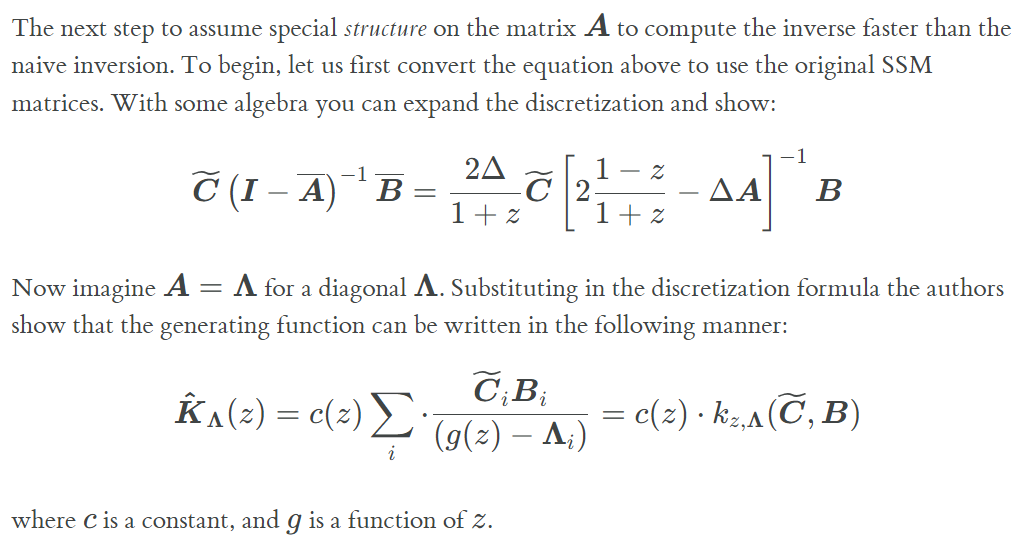

事実上、逆行列を重み付きドット積に置き換えたことになります。この重み付きドット積を計算する小さなヘルパー関数を作って使ってみましょう。

In [ ]:
def caushy_dot(v, omega, lambd):
    return (v / (omega - lambd)).sum()

## Step 3: Diagonal Plus Low-Rank  
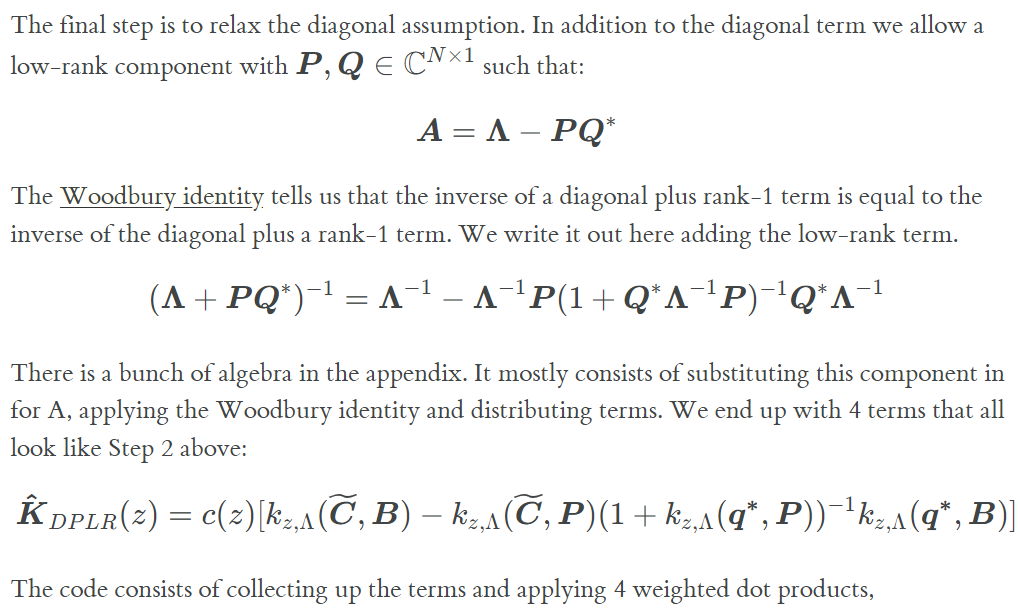